In [1]:
import qutip as qt
import numpy as np
from math import sqrt
import cvxpy as cp

In [2]:
N=20

In [3]:
N = 20 #truncation of Fock space
alpha = sqrt(0.6) #take alpha < 1

psi_0 = qt.coherent(N, 0) #vacuum state
psi_1 = qt.coherent(N, alpha)

delta = abs((psi_0.dag() * psi_1)) #overlap

In [4]:
delta

0.7408182206817177

In [5]:
psi_1

Quantum object: dims=[[20], [1]], shape=(20, 1), type='ket', dtype=Dense
Qobj data =
[[7.40818221e-01]
 [5.73835326e-01]
 [3.14302552e-01]
 [1.40560375e-01]
 [5.44387990e-02]
 [1.88581531e-02]
 [5.96347164e-03]
 [1.74592572e-03]
 [4.78141451e-04]
 [1.23455592e-04]
 [3.02403206e-05]
 [7.06261729e-06]
 [1.57924924e-06]
 [3.39277160e-07]
 [7.02370450e-08]
 [1.40474092e-08]
 [2.72026765e-09]
 [5.11060111e-10]
 [9.32311329e-11]
 [1.70560106e-11]]

In [3]:
M1 = qt.qeye(N) - qt.fock(N,0) * qt.fock(N,0).dag() #the detector clicks for any number of photons (?)

In [4]:
def measure(state, eff=1):
    prob = abs((state.dag() * M1 * state).real)
    if np.random.rand() < prob:
        if np.random.rand() < eff:
            return 1
        else:
            return 0
    else:
        return 0

In [5]:
def pick_x(px1):
    if np.random.rand() < px1:
        return 1
    else:
        return 0

In [8]:
data = []

for i in range(100000):
    x = pick_x(7/8)
    if x:
        b = measure(psi_1, 0.77)
        data.append((b,x))
    else:
        b = measure(psi_0, 0.77)
        data.append((b,x))

In [6]:
def get_stat(data):
    N_0 = 0
    N_1 = 0
    Ninc_0 = 0
    Ninc_1 = 0
    N1_0 = 0
    N1_1 = 0

    for d in data:
        if d[1] :
            N_1 += 1
            if d[0]:
                N1_1 += 1
            else:
                Ninc_1 += 1
        else:                
            N_0 += 1
            if d[0]:
                N1_0 += 1
            else:
                Ninc_0 += 1

    pinc_0 = Ninc_0/N_0
    pinc_1 = Ninc_1/N_1
    p1_0 = N1_0/N_0
    p1_1 = N1_1/N_1

    return pinc_0, pinc_1, p1_0, p1_1, Ninc_0, Ninc_1, N1_0, N1_1, N_0, N_1

In [10]:
pinc_0, pinc_1, p1_0, p1_1, Ninc_0, Ninc_1, N1_0, N1_1, N_0, N_1 = get_stat(data)

In [11]:
pinc_0, pinc_1, p1_0, p1_1, Ninc_0, Ninc_1, N1_0, N1_1, N_0, N_1

(1.0,
 0.654035224421043,
 0.0,
 0.345964775578957,
 12731,
 57077,
 0,
 30192,
 12731,
 87269)

In [21]:
(1/8 + 7*pinc_1/8)

0.9225431808049748

In [7]:
def get_pg(pinc_0, pinc_1, p1_0, p1_1, delta):

    H00 = cp.Variable((2,2), hermitian = True)
    H01 = cp.Variable((2,2), hermitian = True)
    H10 = cp.Variable((2,2), hermitian = True)
    H11 = cp.Variable((2,2), hermitian = True)

    muinc0 = cp.Variable(1)
    muinc1 = cp.Variable(1)
    mu00 = cp.Variable(1)
    mu01 = cp.Variable(1)
    mu10 = cp.Variable(1)
    mu11 = cp.Variable(1)

    rho0 = np.array([[1.,0],[0,0]])
    rho1 = np.array([[delta**2, delta*np.sqrt(1-delta**2)], [delta*np.sqrt(1-delta**2), 1-delta**2]]) #use qubits as in appendix, might be wrong. Also states not normalized so maybe problem.
    rho1 = rho1 / np.trace(rho1)

    constraints = [(rho0 * (1/8 - muinc0) + rho1 * (7/8 - muinc1) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - muinc0) - rho1 * (muinc1) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(-rho0 * (muinc0) + rho1 * (7/8 - muinc1) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(-rho0 * (muinc0) - rho1 * (muinc1) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    constraints += [(-rho0 * (mu00) - rho1 * (mu01) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0] #These are useless
    constraints += [(-rho0 * (mu00) + rho1 * (7/8 - mu01) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu00) - rho1 * (mu01) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu00) + rho1 * (7/8 - mu01) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    constraints += [(-rho0 * (mu10) - rho1 * (mu11) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0]
    constraints += [(-rho0 * (mu10) + rho1 * (7/8 - mu11) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu10) - rho1 * (mu11) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu10) + rho1 * (7/8 - mu11) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    obj = cp.real((muinc0 * pinc_0 + muinc1 * pinc_1 + mu10 * p1_0 + mu11 * p1_1))
                    # cp.abs(muinc0) * t(10**(-9), Ninc_0+N1_0) - cp.abs(muinc1) * t(10**(-9), Ninc_1+N1_1) - cp.abs(mu10) * t(10**(-9), Ninc_0+N1_0) - 
                    # cp.abs(mu11) * t(10**(-9), Ninc_1+N1_1)))

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver = "MOSEK")

    return prob.value

In [8]:
vals = []
vals2 = []
alphas = []
N = 20

for i in range(100):

    alpha = sqrt(0.1 + i*0.05)
    
    psi_0 = qt.coherent(N, 0) #vacuum state
    psi_1 = qt.coherent(N, alpha)

    delta = abs((psi_0.dag() * psi_1)) #overlap

    data = []

    for i in range(100000):
        x = pick_x(7/8)
        if x:
            b = measure(psi_1, 0.77)
            data.append((b,x))
        else:
            b = measure(psi_0, 0.77)
            data.append((b,x))
    
    pinc_0, pinc_1, p1_0, p1_1, Ninc_0, Ninc_1, N1_0, N1_1, N_0, N_1 = get_stat(data)

    if pinc_1 >= p1_1:
        vals2.append(1/8 + 7/8*pinc_1)
    else:
        vals2.append(1/8 + 7/8*p1_1)

    val = get_pg(pinc_0, pinc_1, p1_0, p1_1, delta)
    vals.append(val)
    alphas.append(alpha)
  

In [9]:
import matplotlib.pyplot as plt

In [12]:
hmins = []
hmins2 = []

for v in vals:
    hmins.append(-np.log2(v))

# for v in vals2:
#     hmins2.append(-np.log2(v))

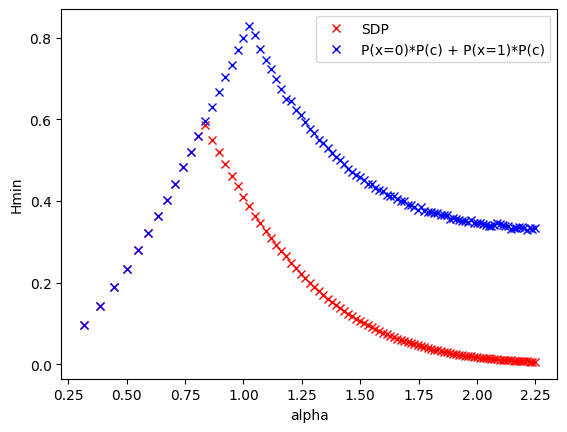

In [11]:
plt.figure()
plt.plot(alphas, hmins, 'rx', label="SDP")
plt.plot(alphas, hmins2, 'bx', label="P(x=0)*P(c) + P(x=1)*P(c)")
plt.xlabel("alpha")
plt.ylabel("Hmin")
plt.legend()

In [7]:
from scipy.special import betaincinv as beta

In [8]:
def qhat(alpha, N, Ntot, Nbx):
    return 1 - beta(Nbx/Ntot * N, N*(1-Nbx/Ntot)+1, alpha)

In [9]:
def get_pg(alphaF, N, Ntot, Ninc_0, Ninc_1, N1_0, N1_1, delta):

    H00 = cp.Variable((2,2), hermitian = True)
    H01 = cp.Variable((2,2), hermitian = True)
    H10 = cp.Variable((2,2), hermitian = True)
    H11 = cp.Variable((2,2), hermitian = True)

    muinc0 = cp.Variable(1)
    muinc1 = cp.Variable(1)
    mu00 = cp.Variable(1)
    mu01 = cp.Variable(1)
    mu10 = cp.Variable(1)
    mu11 = cp.Variable(1)

    rho0 = np.array([[1.,0],[0,0]])
    rho1 = np.array([[delta**2, delta*np.sqrt(1-delta**2)], [delta*np.sqrt(1-delta**2), 1-delta**2]]) #use qubits as in appendix, might be wrong. Also states not normalized so maybe problem.
    rho1 = rho1 / np.trace(rho1)

    constraints = [(rho0 * (1/8 - muinc0) + rho1 * (7/8 - muinc1) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - muinc0) - rho1 * (muinc1) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(-rho0 * (muinc0) + rho1 * (7/8 - muinc1) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(-rho0 * (muinc0) - rho1 * (muinc1) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    constraints += [(-rho0 * (mu00) - rho1 * (mu01) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0] #These are useless
    constraints += [(-rho0 * (mu00) + rho1 * (7/8 - mu01) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu00) - rho1 * (mu01) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu00) + rho1 * (7/8 - mu01) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    constraints += [(-rho0 * (mu10) - rho1 * (mu11) + H00 - 0.5*cp.trace(H00)*np.eye(2)) << 0]
    constraints += [(-rho0 * (mu10) + rho1 * (7/8 - mu11) + H01 - 0.5*cp.trace(H01)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu10) - rho1 * (mu11) + H10 - 0.5*cp.trace(H10)*np.eye(2)) << 0]
    constraints += [(rho0 * (1/8 - mu10) + rho1 * (7/8 - mu11) + H11 - 0.5*cp.trace(H11)*np.eye(2)) << 0]

    constraints += [muinc0 >= 0, muinc1 >= 0, mu00 >= 0, mu01 >= 0, mu10 >= 0, mu11 >= 0]

    qhatinc0 = qhat(alphaF, N, Ntot, Ninc_0)
    # print(qhatinc0)
    qhatinc1 = qhat(alphaF, N, Ntot, Ninc_1)
    # print(qhatinc1)
    qhat10 = qhat(alphaF, N, Ntot, N1_0)
    # print(qhat10)
    qhat11 = qhat(alphaF, N, Ntot, N1_1)
    # print(qhat11)

    obj = cp.real(muinc0/(1/8) * qhatinc0 + muinc1/(7/8) * qhatinc1 + mu11/(7/8) * qhat11)

    prob = cp.Problem(cp.Minimize(obj), constraints)
    prob.solve(solver="MOSEK")

    return prob.value

In [10]:
vals = []
alphas = []
N = 20

for i in range(100):

    alpha = sqrt(0.1 + i*0.05)
    
    psi_0 = qt.coherent(N, 0) #vacuum state
    psi_1 = qt.coherent(N, alpha)

    delta = abs((psi_0.dag() * psi_1)) #overlap

    data = []

    for i in range(100000):
        x = pick_x(7/8)
        if x:
            b = measure(psi_1, 0.77)
            data.append((b,x))
        else:
            b = measure(psi_0, 0.77)
            data.append((b,x))
    
    pinc_0, pinc_1, p1_0, p1_1, Ninc_0, Ninc_1, N1_0, N1_1, N_0, N_1 = get_stat(data)

    val = get_pg(10**(-9), N, 100000, Ninc_0, Ninc_1, N1_0, N1_1, delta)
    vals.append(val)
    alphas.append(alpha)
  

In [11]:
import matplotlib.pyplot as plt

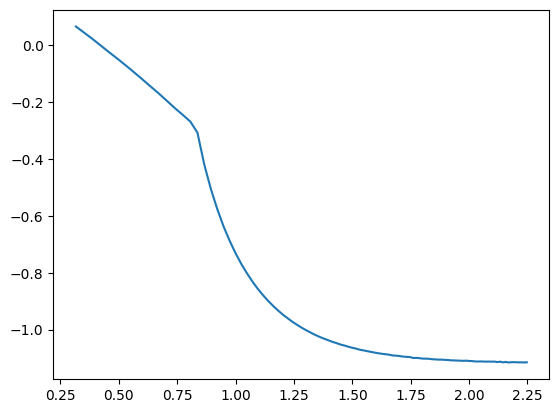

In [13]:
plt.plot(alphas, hmins)

In [23]:
Minc_00 = cp.Variable((2,2), hermitian = True)
Minc_01 = cp.Variable((2,2), hermitian = True)
Minc_10 = cp.Variable((2,2), hermitian = True)
Minc_11 = cp.Variable((2,2), hermitian = True)

M0_00 = cp.Variable((2,2), hermitian = True)
M0_01 = cp.Variable((2,2), hermitian = True)
M0_10 = cp.Variable((2,2), hermitian = True)
M0_11 = cp.Variable((2,2), hermitian = True)

M1_00 = cp.Variable((2,2), hermitian = True)
M1_01 = cp.Variable((2,2), hermitian = True)
M1_10 = cp.Variable((2,2), hermitian = True)
M1_11 = cp.Variable((2,2), hermitian = True)

rho0 = np.array([[1,0],[0,0]])
rho1 = np.array([[delta**2, delta*np.sqrt(1-delta**2)], [delta*np.sqrt(1-delta**2), 1-delta**2]]) #use qubits as in appendix, might be wrong. Also states not normalized so maybe problem.
rho1 = rho1 / np.trace(rho1)

constraints = [Minc_00 >> 0, Minc_01 >> 0, Minc_10 >> 0, Minc_11 >> 0, M0_00 >> 0, M0_01 >> 0, M0_10 >> 0, M0_11 >> 0, M1_00 >> 0, M1_01 >> 0, M1_10 >> 0, M1_11 >> 0]

constraints += [Minc_00 + M0_00 + M1_00 == 0.5*cp.trace(Minc_00+M0_00+M1_00)*np.eye(2), Minc_01 + M0_01 + M1_01 == 0.5*cp.trace(Minc_01+M0_01+M1_01)*np.eye(2),
Minc_10 + M0_10 + M1_10 == 0.5*cp.trace(Minc_10+M0_10+M1_10)*np.eye(2), Minc_11 + M0_11 + M1_11 == 0.5*cp.trace(Minc_11+M0_11+M1_11)*np.eye(2)]

constraints += [cp.trace(rho0@Minc_00) + cp.trace(rho0@Minc_01) + cp.trace(rho0@Minc_10) + cp.trace(rho0@Minc_11) == pinc_0]
constraints += [cp.trace(rho1@Minc_00) + cp.trace(rho1@Minc_01) + cp.trace(rho1@Minc_10) + cp.trace(rho1@Minc_11) == pinc_1]

constraints += [cp.trace(rho0@M0_00) + cp.trace(rho0@M0_01) + cp.trace(rho0@M0_10) + cp.trace(rho0@M0_11) == 0.] #p(0|0) = p(0|1) = 0 bc never b=0
constraints += [cp.trace(rho1@M0_00) + cp.trace(rho1@M0_01) + cp.trace(rho1@M0_10) + cp.trace(rho1@M0_11) == 0.]

constraints += [cp.trace(rho0@M1_00) + cp.trace(rho0@M1_01) + cp.trace(rho0@M1_10) + cp.trace(rho0@M1_11) == p1_0]
constraints += [cp.trace(rho1@M1_00) + cp.trace(rho1@M1_01) + cp.trace(rho1@M1_10) + cp.trace(rho1@M1_11) == p1_1]

obj = cp.real(0.5*(cp.trace(rho0@Minc_00) + cp.trace(rho0@Minc_01) + cp.trace(rho0 @ (np.eye(2) - Minc_10)) + cp.trace(rho0 @ (np.eye(2) - Minc_11))
                + cp.trace(rho1@Minc_00) + cp.trace(rho1 @ (np.eye(2) - Minc_01)) + cp.trace(rho1 @ Minc_10) + cp.trace(rho1 @ (np.eye(2) - Minc_11))))

prob = cp.Problem(cp.Maximize(obj), constraints)
prob.solve()

np.float64(2.624456368758578)

In [84]:
psi = qt.fock(N,1) * 1/np.sqrt(2) + qt.fock(N,0) * 1/np.sqrt(2)

In [86]:
psi.dag() * psi

(0.9999999999999998+0j)

In [88]:
psi_1.dag() * psi_1

(1+0j)

In [89]:
np.sqrt(2*np.log(2))

np.float64(1.1774100225154747)

In [90]:
N = 10 #truncation of Fock space
alpha = np.sqrt(2*np.log(2)) #take alpha < 1

psi_0 = qt.coherent(N, 0) #vacuum state
psi_1 = qt.coherent(N, alpha)

delta = abs((psi_0.dag() * psi_1)) #overlap

In [91]:
delta


0.4999999999719739